In [1]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

In [2]:
DB_FILE = '../backend/customers.db'


conn = sqlite3.connect(DB_FILE)
cursor = conn.cursor()

In [3]:
cursor.execute("SELECT os, screen_resolution, timezone, language, pixel_ratio, cookies_enabled, cpu_cores FROM fingerprints WHERE user_ID = 8")
existing_fingerprints = cursor.fetchall()

X_train = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]),
            fp[4], int(fp[5]), int(fp[6])
        ] for fp in existing_fingerprints[:-4]
    ]

X_outliers = [
        [
            hash(fp[0]), hash(fp[1]), hash('Africa/Cairo'), hash('ar-eg'),
            fp[4], int(fp[5]), int(fp[6])
        ] for fp in existing_fingerprints[-3:]
    ]

print(len(existing_fingerprints))

9


In [4]:
np.random.seed(42)
X_train = np.array(X_train)

# fit the model for novelty detection
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# Predict on test and outlier data
y_pred_outliers = clf.predict(X_outliers)
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size


c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\phili\miniconda3\envs\DigitalBank\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:

In [8]:
print(y_pred_outliers)

[-1 -1 -1]


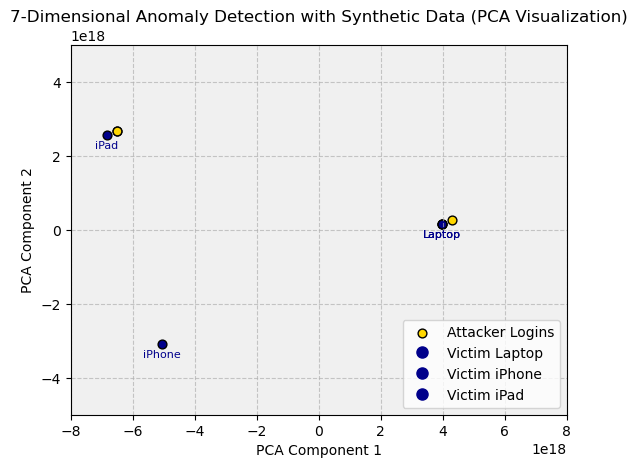

In [ ]:
# For visualization, we'll use PCA to reduce to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_outliers_2d = pca.transform(X_outliers)


plt.title("7-Dimensional Fingerprint Anomaly Detection with Synthetic Attacks (PCA Visualization)")

s = 40
b1 = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c="darkblue", s=s, edgecolors="k")
c = plt.scatter(X_outliers_2d[:, 0], X_outliers_2d[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")

plt.legend(
    [b1, c],
    [
        "Initial Login Devices",
        "Attacker Logins",
    ],
    loc="lower right",
    prop=matplotlib.font_manager.FontProperties(size=11),
)

# Create device type markers for annotation
for i, fp in enumerate(existing_fingerprints[:-4]):
    device_type = "Laptop" if fp[0] == "Win32" else fp[0]
    plt.annotate(device_type, (X_train_2d[i, 0], X_train_2d[i, 1]), 
                 xytext=(0, -10), textcoords='offset points', 
                 fontsize=8, color='darkblue', ha='center')

plt.xlim((-8e18, 8e18))
plt.ylim((-5e18, 5e18))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# Add grey background and grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')

# Add custom device type markers to the legend
laptop_marker = mlines.Line2D([], [], color='darkblue', marker='o', linestyle='None',
                          markersize=8, label='Laptop')
iphone_marker = mlines.Line2D([], [], color='darkblue', marker='o', linestyle='None',
                          markersize=8, label='iPhone')
ipad_marker = mlines.Line2D([], [], color='darkblue', marker='o', linestyle='None',
                        markersize=8, label='iPad')

# Add the device markers to the legend
plt.legend(
    handles=[c, laptop_marker, iphone_marker, ipad_marker],
    labels=[
        "Attacker Logins",
        "Victim Laptop",
        "Victim iPhone",
        "Victim iPad"
    ],
    loc="lower right",
    prop=matplotlib.font_manager.FontProperties(size=10),
)

plt.show()